# Feature Engineering

## Data

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
df = pd.read_csv('https://datasets-nixtla.s3.amazonaws.com/air-passengers.csv', parse_dates=['ds'])
df['ds'] = df['ds'] + pd.offsets.MonthEnd()
df['log_y'] = np.log(df.y+1)
df.set_index(pd.PeriodIndex(pd.date_range("1949-01-31", periods=len(df), freq="M")), inplace=True)
y = df.log_y

<Axes: >

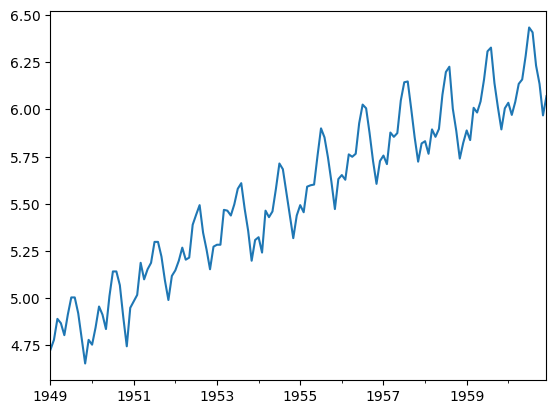

In [ ]:
df['log_y'].plot()

It has been established that our data is clearly seasonal, which we can easily confirm using either autocorrelation or periodogram plots:

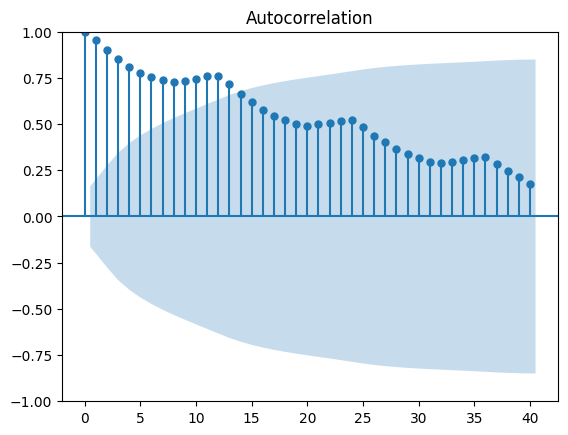

In [ ]:
import statsmodels.api as sm
sm.graphics.tsa.plot_acf(y, lags=40);

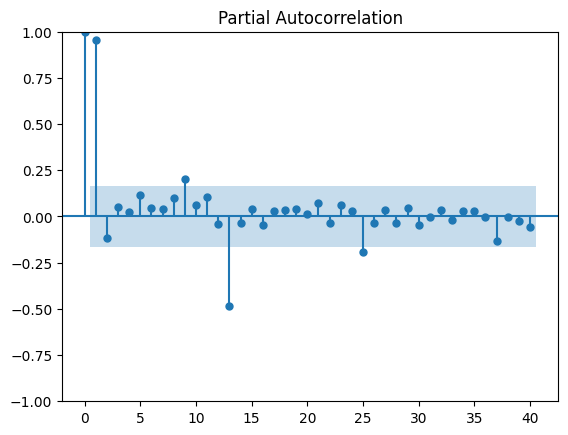

In [ ]:
sm.graphics.tsa.plot_pacf(y, lags=40);

In [ ]:
pacf_vals = sm.tsa.stattools.pacf(y, nlags=40)[1:]
pacf_vals

array([ 0.96039521, -0.13870442,  0.06781737,  0.02641841,  0.14054903,
        0.04922477,  0.04920434,  0.12522629,  0.25979188,  0.08627312,
        0.15684915, -0.03781169, -0.63022644, -0.05491178,  0.06275149,
       -0.06808396,  0.05698911,  0.07856771,  0.07181871,  0.0190693 ,
        0.08727588, -0.08016301,  0.07454875,  0.05781114, -0.2825375 ,
       -0.07032953,  0.07022819, -0.06639509,  0.10659408, -0.06632361,
       -0.03381164,  0.10401115, -0.07290864,  0.04613163,  0.07196465,
       -0.0484499 , -0.254701  ,  0.00984642, -0.0949896 , -0.16438726])

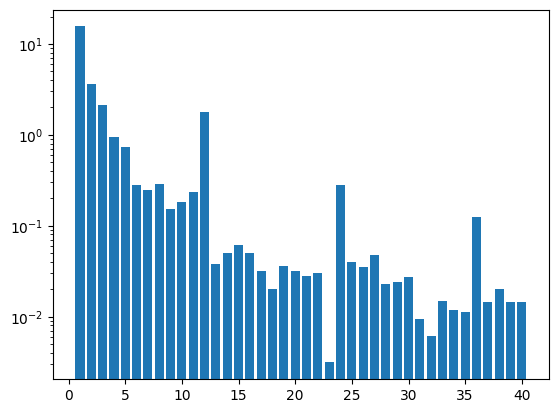

In [ ]:
from scipy import signal
period_vals = signal.periodogram(y)[1][1:41]
plt.bar(np.arange(len(period_vals))+1, period_vals)
plt.yscale('log')

## SARIMA

One way of handling seasonal data is to use an extended - seasonal - ARIMA model. It follows the same principles of the traditional ARIMA model but it incorporates another set of autoregressive and moving average terms based on the length of the detected seasonality.

> SARIMA models take seasonality into account by essentially applying an ARIMA model to lags that are integer multiples of seasonality. Once the seasonality is modelled, an ARIMA model is applied to the leftover to capture non-seasonal structure.
>
> Source: [From AR to SARIMAX: Mathematical Definitions of Time Series Models](https://phosgene89.github.io/sarima.html)

In [ ]:
model = sm.tsa.statespace.SARIMAX(endog=df['log_y'], order=(1,1,0), seasonal_order=(1,0,0,12))
results = model.fit()
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              log_y   No. Observations:                  144
Model:             SARIMAX(1, 1, 0)x(1, 0, 0, 12)   Log Likelihood                 238.650
Date:                            Tue, 06 Feb 2024   AIC                           -471.301
Time:                                    14:59:12   BIC                           -462.412
Sample:                                01-31-1949   HQIC                          -467.689
                                     - 12-31-1960                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2906      0.067     -4.361      0.000      -0.421      -0.160
ar.S.L12       0.9288      0.028   

### Forecasting

In [ ]:
results.forecast(12)

1961-01    6.098356
1961-02    6.038547
1961-03    6.102672
1961-04    6.191178
1961-05    6.213036
1961-06    6.329165
1961-07    6.468861
1961-08    6.444697
1961-09    6.281162
1961-10    6.191181
1961-11    6.036212
1961-12    6.130973
Freq: M, Name: predicted_mean, dtype: float64

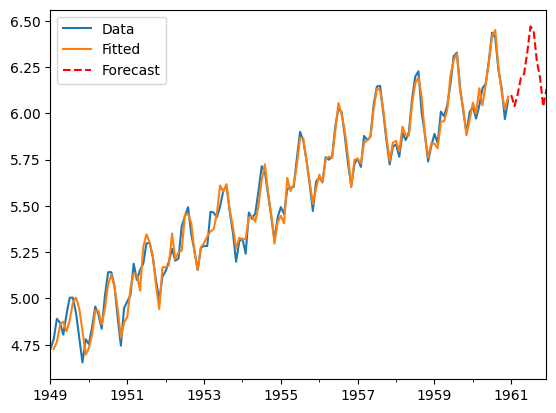

In [ ]:
df['log_y'].plot(label='Data')
results.predict()[1:].plot(label='Fitted')
results.forecast(12).plot(c='r', label='Forecast', linestyle='--')
plt.legend()

# Feature Engineering

There are alternative ways of handling seasonal or temporal features, though. In this section, we'll discuss some of the peculiar ways we can engineer features that are up for the job. For some more details, check Scikit-Learn's documentation [here](https://scikit-learn.org/stable/auto_examples/applications/plot_cyclical_feature_engineering.html).

### Time

The most basic feature is time itself, as a sequential number indicating its passage. In most cases, the **trend** is going to be a function of this fundamental feature.

In [ ]:
df['t'] = pd.RangeIndex(len(df))
df

,unique_id,ds,y,log_y,t
1949-01,AirPassengers,1949-01-31,112,4.727388,0
1949-02,AirPassengers,1949-02-28,118,4.779123,1
1949-03,AirPassengers,1949-03-31,132,4.890349,2
1949-04,AirPassengers,1949-04-30,129,4.867534,3
1949-05,AirPassengers,1949-05-31,121,4.804021,4
...,...,...,...,...,...
1960-08,AirPassengers,1960-08-31,606,6.408529,139
1960-09,AirPassengers,1960-09-30,508,6.232448,140
1960-10,AirPassengers,1960-10-31,461,6.135565,141
1960-11,AirPassengers,1960-11-30,390,5.968708,142


### Dummy Variables

We can also create dummy variables for elements of time, such as months (since it's a monthly series). Notice that this is a *cyclical* feature, unlike time itself.

In [ ]:
df['month'] = df['ds'].dt.month
df

,unique_id,ds,y,log_y,t,month
1949-01,AirPassengers,1949-01-31,112,4.727388,0,1
1949-02,AirPassengers,1949-02-28,118,4.779123,1,2
1949-03,AirPassengers,1949-03-31,132,4.890349,2,3
1949-04,AirPassengers,1949-04-30,129,4.867534,3,4
1949-05,AirPassengers,1949-05-31,121,4.804021,4,5
...,...,...,...,...,...,...
1960-08,AirPassengers,1960-08-31,606,6.408529,139,8
1960-09,AirPassengers,1960-09-30,508,6.232448,140,9
1960-10,AirPassengers,1960-10-31,461,6.135565,141,10
1960-11,AirPassengers,1960-11-30,390,5.968708,142,11


The month's number (or name) is a categorical feature, so it can also be handled directly by statsmodels' own `C()` element in a formula, as shown below:

In [ ]:
import statsmodels.formula.api as smf

# https://www.statsmodels.org/stable/example_formulas.html

mod_dummy = smf.ols("log_y ~ t + C(month)", data=df).fit()
mod_dummy.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  log_y   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                     652.7
Date:                Tue, 06 Feb 2024   Prob (F-statistic):          1.66e-110
Time:                        15:03:01   Log-Likelihood:                 210.28
No. Observations:                 144   AIC:                            -394.6
Df Residuals:                     131   BIC:                            -355.9
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          4.7446      0.019    253.507      0.000       4.708       4.782
C(month)[T.2]     -0.0220      0.024     -0.917      0.361      -0.070       0.026
C(month)[T.3]      0.1076      0.024      4.474      0.000       0.060       0.155
C(month)[T.4]      0.0765      0.024      3.181      0.002       0.029       0.124
C(month)[T.5]      0.0742      0.024      3.085      0.002       0.027       0.122
C(month)[T.6]      0.1958      0.024      8.142      0.000       0.148       0.243
C(month)[T.7]      0.2994      0.024     12.447      0.000       0.252       0.347
C(month)[T.8]      0.2902      0.024     12.060      0.000       0.243       0.338
C(month)[T.9]      0.1460      0.024      6.068      0.000       0.098       0.194
C(month)[T.10]     0.0084      0.024      0.351      0.726      -0.039       0.056
C(month)[T.11]    -0.1346      0.024     -5.590      0.000      -0.182      -0.087
C(month)[T.12]    -0.0213      0.024     -0.885      0.378      -0.069       0.026
t                  0.0100      0.000     84.613      0.000       0.010       0.010
==============================================================================
Omnibus:                        2.658   Durbin-Watson:                   0.427
Prob(Omnibus):                  0.265   Jarque-Bera (JB):                2.389
Skew:                          -0.223   Prob(JB):                        0.303
Kurtosis:                       2.553   Cond. No.                     1.03e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.03e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

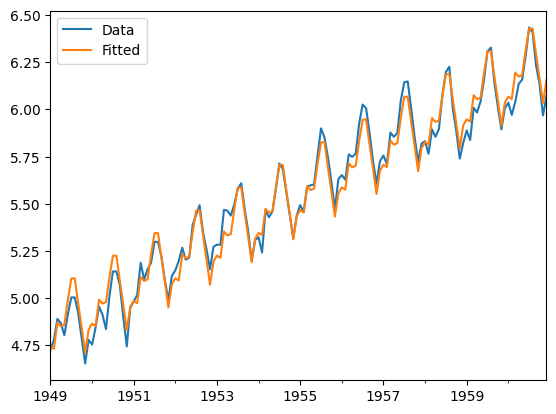

In [ ]:
df['log_y'].plot(label='Data')
mod_dummy.predict(df[['month', 't']]).plot(label='Fitted')
plt.legend()

#### Patsy

Under the hood, statsmodels uses patsy, a library that can be used to translate formulas (as they're used in R) to Pandas dataframes:

In [ ]:
# https://towardsdatascience.com/patsy-build-powerful-features-with-arbitrary-python-code-bb4bb98db67a
import patsy
y, X = patsy.dmatrices('log_y ~ t + C(month)', df, return_type='dataframe')
X

,Intercept,C(month)[T.2],C(month)[T.3],C(month)[T.4],C(month)[T.5],C(month)[T.6],C(month)[T.7],C(month)[T.8],C(month)[T.9],C(month)[T.10],C(month)[T.11],C(month)[T.12],t
1949-01,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1949-02,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1949-03,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
1949-04,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
1949-05,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1960-08,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,139.0
1960-09,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,140.0
1960-10,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,141.0
1960-11,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,142.0


### Forecast using Future Covariates

These features - time and month - are also known as covariates. In this case, we *do* know them ahead of time. We know that February will follow January, and that, if our series had 143 elements up to now, the next one will be the 144th. They are **future covariates** because we know their values in advance.

We can build a simple DF with the values we know in order to make a forecast:

In [ ]:
future_dates = pd.DataFrame.from_dict({'month': np.arange(1, 13),
                                       't': np.arange(144, 156)})
future_dates.set_index(pd.PeriodIndex(pd.date_range("1961-01-31", periods=12, freq="M")), inplace=True)

future_dates

,month,t
1961-01,1,144
1961-02,2,145
1961-03,3,146
1961-04,4,147
1961-05,5,148
1961-06,6,149
1961-07,7,150
1961-08,8,151
1961-09,9,152
1961-10,10,153


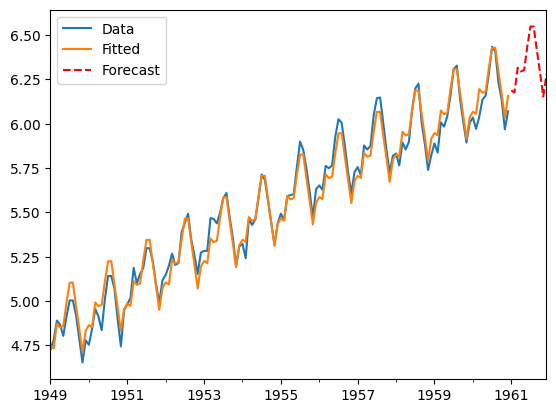

In [ ]:
df['log_y'].plot(label='Data')
mod_dummy.predict(df[['month', 't']]).plot(label='Fitted')
mod_dummy.predict(future_dates).plot(c='r', label='Forecast', linestyle='--')
plt.legend()

## Fourier / Harmonic Features

Even though we're used to representing months as a sequence of numbers from 1 to 12, this representation is not the most accurate one.

December is as close to January as it is to November, right? Both November and January are one month apart from December. In their standard numerical representation, however, November is ONE unit away from December while January is ELEVEN units away from December. This doesn't seem right, right?

The thing is, months are cyclical, not linear. They're better represented as a *circle*, as depicted in the figure below:

![](https://upload.wikimedia.org/wikipedia/commons/thumb/4/40/Months_circle_svg.svg/569px-Months_circle_svg.svg.png)
Source: Licensed under CC-BY-SA 4.0 by Jochen Burghardt, [Wikimedia](https://commons.wikimedia.org/wiki/File:Months_circle_svg.svg)

I don't know about you, but whenever circles are brought into the spotlight, trigonometric functions come to my mind, such as sine and cosine waves.

Sine and cosine values can be used to pinpoint any location around a circle. So, we can divide the circle into twelve parts - one for each month - and use their corresponding sine and cosine values to represent any given month.

This can be easily accomplished by calling functions in patsy, for example:

In [ ]:
def fourier_sin(t, k=1, m=12):
    return np.sin(2*t*np.pi*k/m)

def fourier_cos(t, k=1, m=12):
    return np.cos(2*t*np.pi*k/m)

y, X = patsy.dmatrices('log_y ~ t + fourier_sin(t+1) + fourier_cos(t+1)', df, return_type='dataframe')
X

,Intercept,t,fourier_sin(t + 1),fourier_cos(t + 1)
1949-01,1.0,0.0,5.000000e-01,8.660254e-01
1949-02,1.0,1.0,8.660254e-01,5.000000e-01
1949-03,1.0,2.0,1.000000e+00,6.123234e-17
1949-04,1.0,3.0,8.660254e-01,-5.000000e-01
1949-05,1.0,4.0,5.000000e-01,-8.660254e-01
...,...,...,...,...
1960-08,1.0,139.0,-8.660254e-01,-5.000000e-01
1960-09,1.0,140.0,-1.000000e+00,-1.175970e-14
1960-10,1.0,141.0,-8.660254e-01,5.000000e-01
1960-11,1.0,142.0,-5.000000e-01,8.660254e-01


In [ ]:
mod_fourier = smf.ols('log_y ~ t + fourier_sin(t+1, k=1) + fourier_cos(t+1, k=1)', data=df).fit()
mod_fourier.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  log_y   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     1115.
Date:                Tue, 06 Feb 2024   Prob (F-statistic):           1.75e-97
Time:                        15:09:38   Log-Likelihood:                 145.99
No. Observations:                 144   AIC:                            -284.0
Df Residuals:                     140   BIC:                            -272.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   4.8320      0.015    326.768      0.000       4.803       4.861
t                           0.0100      0.000     55.862      0.000       0.010       0.010
fourier_sin(t + 1, k=1)    -0.0493      0.011     -4.691      0.000      -0.070      -0.029
fourier_cos(t + 1, k=1)    -0.1412      0.010    -13.454      0.000      -0.162      -0.120
==============================================================================
Omnibus:                        2.751   Durbin-Watson:                   1.051
Prob(Omnibus):                  0.253   Jarque-Bera (JB):                2.458
Skew:                          -0.227   Prob(JB):                        0.293
Kurtosis:                       2.548   Cond. No.                         165.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

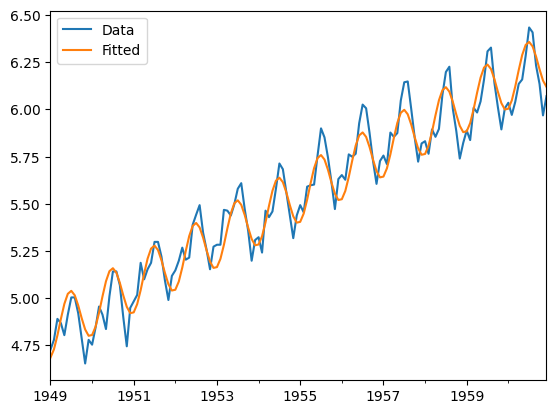

In [ ]:
df['log_y'].plot(label='Data')
mod_fourier.predict(df[['month', 't']]).plot(label='Fitted')
plt.legend()

We're representing our series using a single frequency (there's only one sine and one cosine term), so the fitted values are really smooth, and following a trend (given by the `t` feature).

For more details, see [here](https://otexts.com/fpp3/complexseasonality.html#dynamic-harmonic-regression-with-multiple-seasonal-periods).

### Forecast

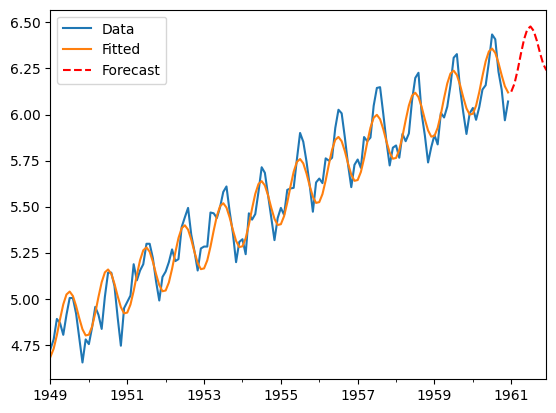

In [ ]:
df['log_y'].plot(label='Data')
mod_fourier.predict(df[['month', 't']]).plot(label='Fitted')
mod_fourier.predict(future_dates).plot(c='r', label='Forecast', linestyle='--')
plt.legend()

### `DeterministicProcess`

Statsmodels also offers an alternative to build the features we've discussed above.

> _Directly supports constants, time trends, and either seasonal dummies or fourier terms for a single cycle. Additional deterministic terms beyond the set that can be directly initialized through the constructor can be added._
>
> Source: [DeterministicProcess](https://www.statsmodels.org/stable/generated/statsmodels.tsa.deterministic.DeterministicProcess.html)

In the example below, we're using two frequencies now (order=2), so there are two sine and two cosine terms in the equation.

In [ ]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

cfr = CalendarFourier(freq='Y', order=2)
seasonal_trig = DeterministicProcess(index=df.index, seasonal=False, additional_terms=[cfr]).in_sample()
seasonal_trig

,"sin(1,freq=A-DEC)","cos(1,freq=A-DEC)","sin(2,freq=A-DEC)","cos(2,freq=A-DEC)"
1949-01,0.000000,1.000000,0.000000,1.000000
1949-02,0.508671,0.860961,0.875892,0.482508
1949-03,0.849817,0.527078,0.895839,-0.444378
1949-04,0.999769,0.021516,0.043022,-0.999074
1949-05,0.880012,-0.474951,-0.835925,-0.548843
...,...,...,...,...
1960-08,-0.492548,-0.870285,0.857315,0.514793
1960-09,-0.866025,-0.500000,0.866025,-0.500000
1960-10,-0.999963,-0.008583,0.017166,-0.999853
1960-11,-0.866025,0.500000,-0.866025,-0.500000


### Scikit-Learns's `FunctionTransformer`

If you're using a pipeline in Scikit-Learn, you may also wrap the sine and cosine functions with `FunctionTransformer`.

In [ ]:
from sklearn.preprocessing import FunctionTransformer

# Cyclical encoding with sine/cosine transformation
# ==============================================================================
def sin_transformer(m, k=1):
    """
    Returns a transformer that applies sine transformation to a variable using
    the specified period.
    """
    return FunctionTransformer(lambda t: np.sin(2*t*np.pi*k/m))

def cos_transformer(m, k=1):
    """
    Returns a transformer that applies cosine transformation to a variable using
    the specified period.
    """
    return FunctionTransformer(lambda t: np.cos(2*t*np.pi*k/m))

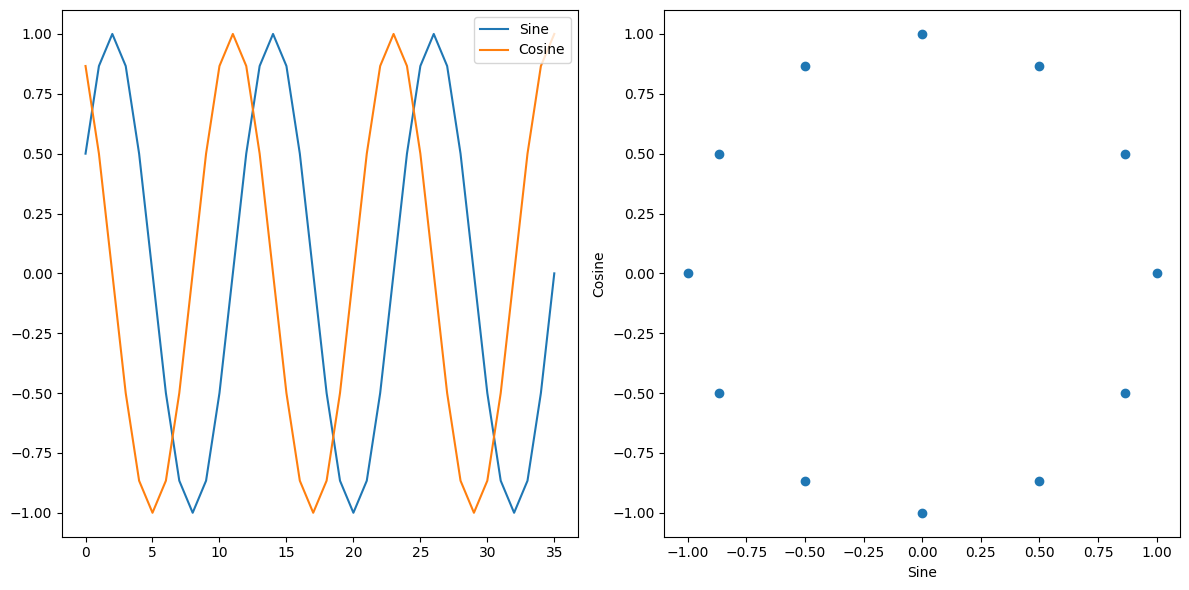

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
sint1 = sin_transformer(m=12, k=1)
cost1 = cos_transformer(m=12, k=1)
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].plot(sint1.transform(np.arange(1, 37)), label='Sine')
axs[0].plot(cost1.transform(np.arange(1, 37)), label='Cosine')
axs[0].legend()
axs[1].scatter(sint1.transform(np.arange(1, 13)), cost1.transform(np.arange(1, 13)))
axs[1].set_xlabel('Sine')
axs[1].set_ylabel('Cosine')
fig.tight_layout()

## Lagged

Lags and lagged features are at the heart of traditional models such as ARIMA. These models use past values of the target series, that is, the series we're making a forecast for.

It is also possible to use past values of related - external - series. In this case, we're talking about **past covariates** because - unlike the months or other time elements that inexorably follow one another - we **don't know them ahead of time**.

Lags can be easily computed using Pandas series and its `shift()` method:

In [ ]:
def lag(x, n):
    if n == 0:
        return x
    if isinstance(x, pd.Series):
        return x.shift(n)
    else:
        x = pd.Series(x)
        return x.shift(n)

In [ ]:
lag(df['log_y'], 1), lag(df['log_y'], 12)

(1949-01         NaN
 1949-02    4.727388
 1949-03    4.779123
 1949-04    4.890349
 1949-05    4.867534
              ...   
 1960-08    6.434547
 1960-09    6.408529
 1960-10    6.232448
 1960-11    6.135565
 1960-12    5.968708
 Freq: M, Name: log_y, Length: 144, dtype: float64,
 1949-01         NaN
 1949-02         NaN
 1949-03         NaN
 1949-04         NaN
 1949-05         NaN
              ...   
 1960-08    6.327937
 1960-09    6.139885
 1960-10    6.011267
 1960-11    5.894403
 1960-12    6.006353
 Freq: M, Name: log_y, Length: 144, dtype: float64)

Once again, we can call the `lag()` function from a formula in patsy:

In [ ]:
y, X = patsy.dmatrices('log_y ~ lag(log_y, 12) + lag(log_y, 1)', df, return_type='dataframe')
X

,Intercept,"lag(log_y, 12)","lag(log_y, 1)"
1950-01,1.0,4.727388,4.779123
1950-02,1.0,4.779123,4.753590
1950-03,1.0,4.890349,4.844187
1950-04,1.0,4.867534,4.955827
1950-05,1.0,4.804021,4.912655
...,...,...,...
1960-08,1.0,6.327937,6.434547
1960-09,1.0,6.139885,6.408529
1960-10,1.0,6.011267,6.232448
1960-11,1.0,5.894403,6.135565


In [ ]:
mod_lag = smf.ols('log_y ~ lag(log_y, 12) + lag(log_y, 1)', data=df).fit()
mod_lag.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  log_y   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                     3510.
Date:                Tue, 06 Feb 2024   Prob (F-statistic):          3.40e-113
Time:                        15:13:46   Log-Likelihood:                 198.87
No. Observations:                 132   AIC:                            -391.7
Df Residuals:                     129   BIC:                            -383.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.2648      0.066      4.031      0.000       0.135       0.395
lag(log_y, 12)     0.7680      0.040     19.122      0.000       0.689       0.847
lag(log_y, 1)      0.2015      0.041      4.906      0.000       0.120       0.283
==============================================================================
Omnibus:                        2.001   Durbin-Watson:                   0.883
Prob(Omnibus):                  0.368   Jarque-Bera (JB):                1.722
Skew:                          -0.278   Prob(JB):                        0.423
Kurtosis:                       3.057   Cond. No.                         114.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

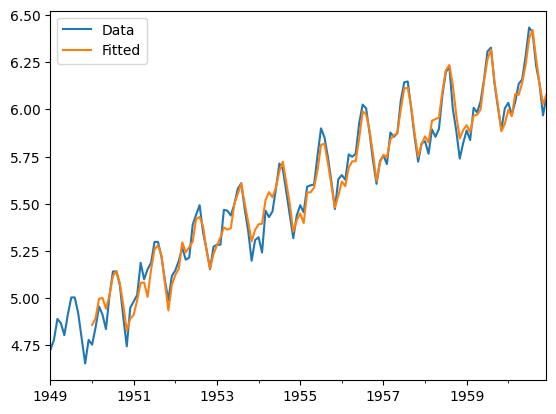

In [ ]:
df['log_y'].plot(label='Data')
mod_lag.predict(df[['log_y']]).plot(label='Fitted')
plt.legend()

### Forecast

Just like last time, we need to build a DF containing the features our model uses. Last time, we had `t` and `month` as features and, since they are both *future covariates*, it was straightforward.

This time, however, our model also uses lagged versions of the *target* series itself. So, we need to add the corresponding column to our DF.

But, this poses a major problem. We *don't know* these values just yet! How can we possible build the DF? We can start with a bunch of zeros, so we get the structure right, at least.

In [ ]:
future_dates = pd.DataFrame.from_dict({'month': np.arange(1, 13),
                                       't': np.arange(144, 156),
                                       'log_y': np.zeros(12,)})
future_dates.set_index(pd.PeriodIndex(pd.date_range("1961-01-31", periods=12, freq="M")), inplace=True)
future_dates

,month,t,log_y
1961-01,1,144,0.0
1961-02,2,145,0.0
1961-03,3,146,0.0
1961-04,4,147,0.0
1961-05,5,148,0.0
1961-06,6,149,0.0
1961-07,7,150,0.0
1961-08,8,151,0.0
1961-09,9,152,0.0
1961-10,10,153,0.0


But, our model's formula (`log_y ~ lag(log_y, 12) + lag(log_y, 1)`) requires 12 lags from the past, so we concatenate those together:

In [ ]:
last_and_future = pd.concat([df[['month', 't', 'log_y']].iloc[-12:], future_dates])
last_and_future

,month,t,log_y
1960-01,1,132,6.035481
1960-02,2,133,5.971262
1960-03,3,134,6.040255
1960-04,4,135,6.135565
1960-05,5,136,6.159095
1960-06,6,137,6.284134
1960-07,7,138,6.434547
1960-08,8,139,6.408529
1960-09,9,140,6.232448
1960-10,10,141,6.135565


We can "see" what the model is going to use by recreating the underlying feature matrix using patsy:

In [ ]:
_, X = patsy.dmatrices('log_y ~ lag(log_y, 12) + lag(log_y, 1)', last_and_future, return_type='dataframe')
X

,Intercept,"lag(log_y, 12)","lag(log_y, 1)"
1961-01,1.0,6.035481,6.070738
1961-02,1.0,5.971262,0.000000
1961-03,1.0,6.040255,0.000000
1961-04,1.0,6.135565,0.000000
1961-05,1.0,6.159095,0.000000
1961-06,1.0,6.284134,0.000000
1961-07,1.0,6.434547,0.000000
1961-08,1.0,6.408529,0.000000
1961-09,1.0,6.232448,0.000000
1961-10,1.0,6.135565,0.000000


It's all good and well for the middle column - which uses lagged values from 12 steps in the past. But, the last column, which uses lagged values from a single step in the past **only works for the very first step**.

This shouldn't be exaclty a surprise, right? The only time step where this information is actually available is the first, because it uses the last observed value. After that, we're in the dark. We don't know the future.

So, if we use our model to make a forecast, the only sensible forecast is the first one. The remaining values are impacted by the zeros representing the unknown future.

In [ ]:
predictions = mod_lag.predict(last_and_future)[12:]
predictions

1961-01    6.123205
1961-02    4.850730
1961-03    4.903717
1961-04    4.976916
1961-05    4.994987
1961-06    5.091018
1961-07    5.206536
1961-08    5.186554
1961-09    5.051323
1961-10    4.976916
1961-11    4.848768
1961-12    4.927128
Freq: M, dtype: float64

### Forecasts as Features

We don't know the future (which is January 1961 in our dataset), but now we *do* have a forecast. What if we feed the forecast back into our feature matrix, and run the model once again?

In [ ]:
last_and_future.loc[pd.Period('1961-01'), 'log_y'] = predictions.loc[pd.Period('1961-01')]
last_and_future

,month,t,log_y
1960-01,1,132,6.035481
1960-02,2,133,5.971262
1960-03,3,134,6.040255
1960-04,4,135,6.135565
1960-05,5,136,6.159095
1960-06,6,137,6.284134
1960-07,7,138,6.434547
1960-08,8,139,6.408529
1960-09,9,140,6.232448
1960-10,10,141,6.135565


In [ ]:
predictions = mod_lag.predict(last_and_future)[12:]
predictions

1961-01    6.123205
1961-02    6.084455
1961-03    4.903717
1961-04    4.976916
1961-05    4.994987
1961-06    5.091018
1961-07    5.206536
1961-08    5.186554
1961-09    5.051323
1961-10    4.976916
1961-11    4.848768
1961-12    4.927128
Freq: M, dtype: float64

Now, the second value is a forecast that is based on the previous forecast. For all intents and purposes, we're assuming the forecast is right on the money, and it's the lagged value that feeds the forecast for two time steps ahead.

We can do it recursively and get forecasts for as many time steps ahead as we'd like. This is the nature of an **autoregressive model**. However, the more forecasts we use as inputs, the less reliable further forecasting into the future is going to be.

In [ ]:
for t in future_dates.index:
    predictions = mod_lag.predict(last_and_future)
    last_and_future.loc[t, 'log_y'] = predictions.loc[t]

In [ ]:
last_and_future.loc[pd.Period('1961-01'):]

,month,t,log_y
1961-01,1,144,6.123205
1961-02,2,145,6.084455
1961-03,3,146,6.129635
1961-04,4,147,6.211937
1961-05,5,148,6.246591
1961-06,6,149,6.349604
1961-07,7,150,6.485877
1961-08,8,151,6.493352
1961-09,9,152,6.359627
1961-10,10,153,6.258276


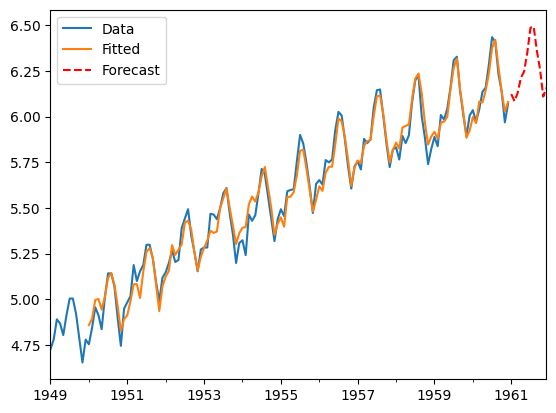

In [ ]:
df['log_y'].plot(label='Data')
mod_lag.predict(df[['log_y']]).plot(label='Fitted')
last_and_future.loc[pd.Period('1961-01'):, 'log_y'].plot(c='r', label='Forecast', linestyle='--')
plt.legend()

It was a lot of work, right? While ooping through forecasts and features, it's easy to make a mistake.

## DARTS

We can actually build the same model using DARTS, and then we don't need to manually handle the forecasting loop anymore.

In [ ]:
!pip install darts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.4/819.4 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 32.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 17.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.7/535.7 kB 35.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.7/120.7 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.9/776.9 kB 38.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 38.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 279.8/279.8 kB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.2/169.2

In [ ]:
from darts import TimeSeries
from darts.models import LinearRegressionModel

model = LinearRegressionModel(
    lags=[-1, -12],
)

new_y = y.copy()
new_y.index = new_y.index.to_timestamp()

ts_y = TimeSeries.from_series(new_y)
model.fit(ts_y)

LinearRegressionModel(lags=[-1, -12], lags_past_covariates=None, lags_future_covariates=None, output_chunk_length=1, add_encoders=None, likelihood=None, quantiles=None, random_state=None, multi_models=True, use_static_covariates=True)

In [ ]:
model.model.coef_

array([0.76066457, 0.18545355])

If you go back to the statsmodels' model we have fitted above, you'll see that both coefficients match.

This time, however, making predictions is a piece of cake:

In [ ]:
pred = model.predict(12)
pred

<TimeSeries (DataArray) (time: 12, component: 1, sample: 1)>
array([[[6.11713858]],

       [[6.07689422]],

       [[6.12191119]],

       [[6.20275882]],

       [[6.23565112]],

       [[6.33686368]],

       [[6.47004726]],

       [[6.47495586]],

       [[6.34192777]],

       [[6.24356168]],

       [[6.09839688]],

       [[6.14908628]]])
Coordinates:
  * time       (time) datetime64[ns] 1961-01-01 1961-02-01 ... 1961-12-01
  * component  (component) object 'log_y'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

<Axes: xlabel='time'>

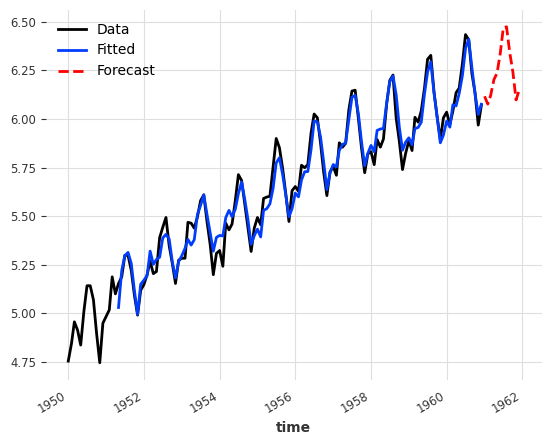

In [ ]:
ts_y.plot(label='Data')
model.historical_forecasts(ts_y)[2:].plot(label='Fitted')
pred.plot(label='Forecast', c='r', linestyle='--')

## Covariates

We've already talked about them: covariates, past and future.

![](https://unit8co.github.io/darts/_images/covariates-highlevel.png)

***
Let’s have a look at some examples of past, future, and static covariates:
- past_covariates: typically measurements (past data) or temporal attributes
   - daily average measured temperatures (known only in the past)
   - day of week, month, year, …
- future_covariates: typically forecasts (future known data) or temporal attributes
  - daily average forecasted temperatures (known in the future)
  - day of week, month, year, …
- static_covariates: time independent/constant/static target characteristics
  - categorical:
      - location of target (country, city, .. name)
      - target identifier: (product ID, store ID, …)
  - numerical:
      - population of target‘s country/market area (assuming it stays constant over the forecasting horizon)
      - average temperature of target‘s region (assuming it stays constant over the forecasting horizon)

Source: [DARTS' documentation](https://unit8co.github.io/darts/userguide/covariates.html)
***

### SkTime

In SkTime, we can create a pipeline to preprocess the target series (e.g. detrending and deseasonalizing) and to create covariates (e.g. datetime attributes and Fourier/harmonic features), as shown in the example below:

In [ ]:
!pip install sktime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 41.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.2/127.2 kB 13.0 MB/s eta 0:00:00


In [ ]:
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.transformations.compose import TransformerPipeline, FeatureUnion
from sktime.transformations.series.detrend import Detrender, Deseasonalizer
from sktime.transformations.series.fourier import FourierFeatures
from sktime.transformations.series.date import DateTimeFeatures

main_series = TransformerPipeline(steps = [
    ("detrended", Detrender(forecaster=PolynomialTrendForecaster(degree=1))),
    ("deseasonalizer", Deseasonalizer(sp=12)),
])

pipe = FeatureUnion([
    ("main", main_series),
    ("ts_feat", DateTimeFeatures(ts_freq="M", feature_scope='comprehensive')),
    ("fourier", FourierFeatures(sp_list=[12], fourier_terms_list=[2])),
])
pipe.fit(y)

FeatureUnion(transformer_list=[('main',
                                TransformerPipeline(steps=[('detrended',
                                                            Detrender(forecaster=PolynomialTrendForecaster())),
                                                           ('deseasonalizer',
                                                            Deseasonalizer(sp=12))])),
                               ('ts_feat',
                                DateTimeFeatures(feature_scope='comprehensive',
                                                 ts_freq='M')),
                               ('fourier',
                                FourierFeatures(fourier_terms_list=[2],
                                                sp_list=[12]))])

We can apply the pipeline to our data and get a dataframe with the transformed target series and the added covariates:

In [ ]:
past_df = pipe.transform(y)
past_df

,main__log_y,ts_feat__year,ts_feat__quarter_of_year,ts_feat__month_of_year,ts_feat__month_of_quarter,fourier__sin_12_1,fourier__cos_12_1,fourier__sin_12_2,fourier__cos_12_2
1950-01,-0.130719,1950,1,1,1,0.000000,1.000000e+00,0.000000e+00,1.0
1950-02,-0.010624,1950,1,2,2,0.500000,8.660254e-01,8.660254e-01,0.5
1950-03,-0.043992,1950,1,3,3,0.866025,5.000000e-01,8.660254e-01,-0.5
1950-04,-0.068297,1950,2,4,1,1.000000,6.123234e-17,1.224647e-16,-1.0
1950-05,-0.167489,1950,2,5,2,0.866025,-5.000000e-01,-8.660254e-01,-0.5
...,...,...,...,...,...,...,...,...,...
1960-08,-0.013741,1960,3,8,2,-0.500000,-8.660254e-01,8.660254e-01,0.5
1960-09,-0.055484,1960,3,9,3,-0.866025,-5.000000e-01,8.660254e-01,-0.5
1960-10,-0.022462,1960,4,10,1,-1.000000,-4.409347e-15,8.818695e-15,-1.0
1960-11,-0.058955,1960,4,11,2,-0.866025,5.000000e-01,-8.660254e-01,-0.5


How can we create such features for future dates? Future covariates are fine because they depend on the future date alone. But, for the first part of the pipeline, it will break unless there's a column for the target series, even if we obviously don't have any values for it.

In [ ]:
fh = pd.DataFrame.from_dict({'log_y': np.zeros(12,)})
fh.set_index(pd.PeriodIndex(pd.date_range("1961-01-31", periods=12, freq="M")), inplace=True)
fh

,log_y
1961-01,0.0
1961-02,0.0
1961-03,0.0
1961-04,0.0
1961-05,0.0
1961-06,0.0
1961-07,0.0
1961-08,0.0
1961-09,0.0
1961-10,0.0


In [ ]:
future_df = pipe.transform(fh)
future_df

,main__log_y,ts_feat__year,ts_feat__quarter_of_year,ts_feat__month_of_year,ts_feat__month_of_quarter,fourier__sin_12_1,fourier__cos_12_1,fourier__sin_12_2,fourier__cos_12_2
1961-01,-6.181173,1961,1,1,1,4.411204e-15,1.000000e+00,8.822409e-15,1.0
1961-02,-6.151675,1961,1,2,2,5.000000e-01,8.660254e-01,8.660254e-01,0.5
1961-03,-6.296683,1961,1,3,3,8.660254e-01,5.000000e-01,8.660254e-01,-0.5
1961-04,-6.277815,1961,2,4,1,1.000000e+00,9.790985e-16,1.958197e-15,-1.0
1961-05,-6.300634,1961,2,5,2,8.660254e-01,-5.000000e-01,-8.660254e-01,-0.5
1961-06,-6.430410,1961,2,6,3,5.000000e-01,-8.660254e-01,-8.660254e-01,0.5
1961-07,-6.536859,1961,3,7,1,6.369401e-15,-1.000000e+00,-1.273880e-14,1.0
1961-08,-6.540167,1961,3,8,2,-5.000000e-01,-8.660254e-01,8.660254e-01,0.5
1961-09,-6.405829,1961,3,9,3,-8.660254e-01,-5.000000e-01,8.660254e-01,-0.5
1961-10,-6.275923,1961,4,10,1,-1.000000e+00,-1.175970e-14,2.351941e-14,-1.0


The values in the transformed target series follow the seasonal pattern, but they're completely off because the transformation assumes a trending series (as opposed to zeros).

### DARTS

In DARTS, we can also create plenty of future covariates using [Datetime Attributes](https://unit8co.github.io/darts/generated_api/darts.utils.timeseries_generation.html#darts.utils.timeseries_generation.datetime_attribute_timeseries).

Just like Scikit-Learn, there's also a [Scaler](https://unit8co.github.io/darts/generated_api/darts.dataprocessing.transformers.scaler.html) that you can apply to the features, should the need arise.

For more details, check DARTS' documentation on [covariates](https://unit8co.github.io/darts/userguide/covariates.html).

In [ ]:
import pandas as pd
from darts import TimeSeries
from darts.utils.timeseries_generation import datetime_attribute_timeseries

full_time_period = pd.date_range(start='2015-01-01', end='2018-12-31', freq='D')

year = datetime_attribute_timeseries(time_index = full_time_period, attribute="year")
month = datetime_attribute_timeseries(time_index = full_time_period, attribute="month")
day = datetime_attribute_timeseries(time_index = full_time_period, attribute="day")
dayofyear = datetime_attribute_timeseries(time_index = full_time_period, attribute="dayofyear")
weekday = datetime_attribute_timeseries(time_index = full_time_period, attribute="dayofweek")
weekofyear = datetime_attribute_timeseries(time_index = full_time_period, attribute="weekofyear")
timesteps = TimeSeries.from_times_and_values(times=full_time_period,
                                             values=np.arange(len(full_time_period)),
                                             columns=["linear_increase"])

time_cov = year.stack(month).stack(day).stack(dayofyear).stack(weekday).stack(weekofyear).stack(timesteps)
time_cov = time_cov.astype(np.float32)

print(time_cov.components.values)
time_cov[10]

['year' 'month' 'day' 'dayofyear' 'dayofweek' 'weekofyear'
 'linear_increase']


<TimeSeries (DataArray) (time: 1, component: 7, sample: 1)>
array([[[2.015e+03],
        [1.000e+00],
        [1.100e+01],
        [1.100e+01],
        [6.000e+00],
        [2.000e+00],
        [1.000e+01]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 2015-01-11
  * component  (component) object 'year' 'month' ... 'linear_increase'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [ ]:
from darts.dataprocessing.transformers import Scaler

time_cov_scaler = Scaler(verbose=False, n_jobs=-1, name="Scaler")
time_cov_train, time_cov_val = time_cov.split_before(pd.Timestamp('2017-08-31'))
time_cov_scaler.fit(time_cov_train)
time_cov_transformed = time_cov_scaler.transform(time_cov)

In [ ]:
time_cov_transformed

<TimeSeries (DataArray) (time: 1461, component: 7, sample: 1)>
array([[[0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00],
        ...,
        [5.0000000e-01],
        [0.0000000e+00],
        [0.0000000e+00]],

       [[0.0000000e+00],
        [0.0000000e+00],
        [3.3333335e-02],
        ...,
        [6.6666669e-01],
        [0.0000000e+00],
        [1.0288066e-03]],

       [[0.0000000e+00],
        [0.0000000e+00],
        [6.6666678e-02],
        ...,
...
        ...,
        [8.3333337e-01],
        [9.8076922e-01],
        [1.5000000e+00]],

       [[1.5000000e+00],
        [1.0000000e+00],
        [9.6666664e-01],
        ...,
        [1.0000000e+00],
        [9.8076922e-01],
        [1.5010288e+00]],

       [[1.5000000e+00],
        [1.0000000e+00],
        [1.0000001e+00],
        ...,
        [0.0000000e+00],
        [0.0000000e+00],
        [1.5020576e+00]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 2015-01-01 2015-01-02 ... 2018-12-31
  * component  (component) object 'year' 'month' ... 'linear_increase'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

### Transformations

DARTS offers many other useful transformations:

- [Box-Cox](https://unit8co.github.io/darts/generated_api/darts.dataprocessing.transformers.boxcox.html)
- [Differencing](https://unit8co.github.io/darts/generated_api/darts.dataprocessing.transformers.diff.html)
- [Missing Values Filler](https://unit8co.github.io/darts/generated_api/darts.dataprocessing.transformers.missing_values_filler.html)
- [Static Covariates](https://unit8co.github.io/darts/generated_api/darts.dataprocessing.transformers.static_covariates_transformer.html)
- [Window](https://unit8co.github.io/darts/generated_api/darts.dataprocessing.transformers.window_transformer.html)
- [Invertible Data](https://unit8co.github.io/darts/generated_api/darts.dataprocessing.transformers.invertible_data_transformer.html)

Let's create a simple pipeline that can fill missing values, apply log transformation (and also provide the possibility of reversing it to output forecasts in their original scale), and scale them (also invertible).

In [ ]:
from darts.datasets import AirPassengersDataset
from darts.dataprocessing import Pipeline
from darts.dataprocessing.transformers import Scaler, StaticCovariatesTransformer, MissingValuesFiller, InvertibleMapper
from sklearn.preprocessing import OneHotEncoder

air = AirPassengersDataset().load()

train_filler = MissingValuesFiller(verbose=False, n_jobs=-1, name="Fill NAs")
log_transformer = InvertibleMapper(np.log1p, np.expm1, verbose=False, n_jobs=-1, name="Log-Transform")
train_scaler = Scaler(verbose=False, n_jobs=-1, name="Scaling")

train_pipeline = Pipeline([train_filler,
                           log_transformer,
                           train_scaler])

<Axes: xlabel='Month'>

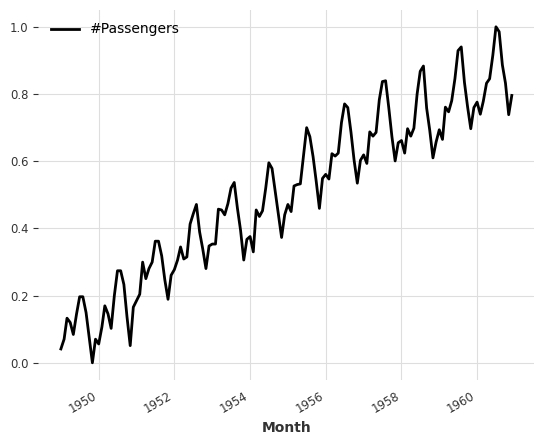

In [ ]:
train_pipeline.fit(air)
air_transf = train_pipeline.transform(air)
air_transf.plot()

If we try to apply the inverse transformation, this is what we'll get:

In [ ]:
train_pipeline.inverse_transform(air_transf)

ERROR:darts.dataprocessing.pipeline:ValueError: Not all transformers in the pipeline can perform inverse_transform


ValueError: Not all transformers in the pipeline can perform inverse_transform

The missing values filler is, obviously, not invertible (why would you want to even do that?!). But, don't despair, we can easily fix this without resorting to crazy workarounds. Simply set `partial` to `True` and you're golden!

<Axes: xlabel='Month'>

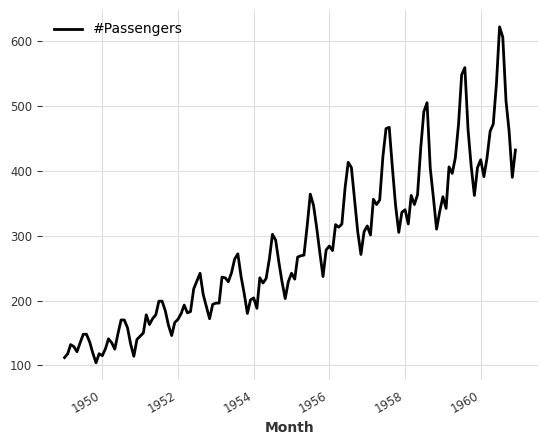

In [ ]:
air_inv = train_pipeline.inverse_transform(air_transf, partial=True)
air_inv.plot()

### `add_encoders()`

There is yet another way of adding lots of covariates without having to create a pipeline. Some models allow you to specify a config dictionary that specifies the desired transformations. Let's use a different dataset for this example:

In [ ]:
from darts.datasets import WeatherDataset
from darts.models import RandomForest

series = WeatherDataset().load()
series.pd_dataframe()

component,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),...,wv (m/s),max. wv (m/s),wd (deg),rain (mm),raining (s),SWDR (W/m²),PAR (µmol/m²/s),max. PAR (µmol/m²/s),Tlog (degC),CO2 (ppm)
Date Time,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:10:00,1008.89,0.71,273.18,-1.33,86.1,6.43,5.54,0.89,3.42,5.49,...,1.02,1.60,224.3,0.0,0.0,0.0,0.0,0.0,11.45,428.1
2020-01-01 00:20:00,1008.76,0.75,273.22,-1.44,85.2,6.45,5.49,0.95,3.39,5.45,...,0.43,0.84,206.8,0.0,0.0,0.0,0.0,0.0,11.51,428.0
2020-01-01 00:30:00,1008.66,0.73,273.21,-1.48,85.1,6.44,5.48,0.96,3.39,5.43,...,0.61,1.48,197.1,0.0,0.0,0.0,0.0,0.0,11.60,427.6
2020-01-01 00:40:00,1008.64,0.37,272.86,-1.64,86.3,6.27,5.41,0.86,3.35,5.37,...,1.11,1.48,206.4,0.0,0.0,0.0,0.0,0.0,11.70,430.0
2020-01-01 00:50:00,1008.61,0.33,272.82,-1.50,87.4,6.26,5.47,0.79,3.38,5.42,...,0.49,1.40,209.6,0.0,0.0,0.0,0.0,0.0,11.81,432.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 23:20:00,978.32,2.28,277.16,-0.80,80.0,7.20,5.76,1.44,3.67,5.89,...,0.73,1.40,180.6,0.0,0.0,0.0,0.0,0.0,13.40,433.0
2020-12-31 23:30:00,978.30,2.13,277.01,-0.43,83.1,7.12,5.92,1.20,3.77,6.05,...,0.43,0.82,174.0,0.0,0.0,0.0,0.0,0.0,13.42,439.6
2020-12-31 23:40:00,978.26,1.99,276.88,-0.71,82.2,7.05,5.80,1.26,3.69,5.93,...,0.38,0.76,248.9,0.0,0.0,0.0,0.0,0.0,13.45,435.2


The target series is the atmospheric pressure. We'll use rainfall as past covariate (observed values) and we'll use future temperatures (as if they were really good forecasts from another source) as future covariate.

In [ ]:
# predicting atmospheric pressure
target = series['p (mbar)'][:100]
# optionally, use past observed rainfall (pretending to be unknown beyond index 100)
past_cov = series['rain (mm)'][:100]
# optionally, use future temperatures (pretending this component is a forecast)
future_cov = series['T (degC)'][:106]

The dictionary looks like this:

In [ ]:
def encode_year(idx):
    return (idx.year - 1950) / 50

add_encoders={
    'cyclic': {'future': ['hour']},
    'datetime_attribute': {'future': ['hour', 'minute', 'dayofweek']},
    'position': {'future': ['relative']},
    'custom': {'future': [encode_year]},
    'transformer': Scaler(),
    'tz': 'CET'
}

***

In the above dictionary, the following things are specified:

- The hour should be used as a future covariate, with a cyclic (sin/cos) encoding.
- The hour, minute, and day-of-the-week should be used as future covariates.
- The absolute position (time step in the series) should be used as past covariates.
- The relative position (w.r.t the forecasting time) should be used as future covariates.
- An additional custom function of the year should be used as past covariates.
- All the above covariates should be scaled using a Scaler, which will be fit upon calling the model fit() function and used afterwards to transform the covariates.

Source: Adapted from [DARTS' documentation](https://unit8co.github.io/darts/quickstart/00-quickstart.html#Encoders:-using-covariates-for-free)

***

The dictionary may be used in a model such as a random forest:

In [ ]:
# random forest with 200 trees trained with MAE
model = RandomForest(
    lags=12,
    lags_past_covariates=12,
    lags_future_covariates=[0,1,2,3,4,5],
    output_chunk_length=6,
    n_estimators=200,
    criterion="absolute_error",
    add_encoders=add_encoders
)

model.fit(target, past_covariates=past_cov, future_covariates=future_cov)
pred = model.predict(6)
pred.values()

array([[1006.17155],
       [1006.1132 ],
       [1006.05   ],
       [1005.9806 ],
       [1005.9434 ],
       [1005.94155]])

What if we actually want to take a peek at the generated features?

In [ ]:
past_enc, fut_enc = model.generate_fit_encodings(target, past_covariates=past_cov, future_covariates=future_cov)
fut_enc.pd_dataframe()

component,T (degC),darts_enc_fc_cyc_hour_sin,darts_enc_fc_cyc_hour_cos,darts_enc_fc_dta_hour,darts_enc_fc_dta_minute,darts_enc_fc_dta_dayofweek,darts_enc_fc_pos_relative,darts_enc_fc_cus_custom
Date Time,,,,,,,,
2020-01-01 00:10:00,0.71,0.258819,9.659258e-01,0.0,0.2,0.0,0.000000,0.0
2020-01-01 00:20:00,0.75,0.258819,9.659258e-01,0.0,0.4,0.0,0.009524,0.0
2020-01-01 00:30:00,0.73,0.258819,9.659258e-01,0.0,0.6,0.0,0.019048,0.0
2020-01-01 00:40:00,0.37,0.258819,9.659258e-01,0.0,0.8,0.0,0.028571,0.0
2020-01-01 00:50:00,0.33,0.258819,9.659258e-01,0.0,1.0,0.0,0.038095,0.0
...,...,...,...,...,...,...,...,...
2020-01-01 17:00:00,2.09,-1.000000,-1.836970e-16,1.0,0.0,0.0,0.961905,0.0
2020-01-01 17:10:00,1.63,-1.000000,-1.836970e-16,1.0,0.2,0.0,0.971429,0.0
2020-01-01 17:20:00,1.26,-1.000000,-1.836970e-16,1.0,0.4,0.0,0.980952,0.0


## Limited Target

Sometimes the target series may only take a limited range of values. It's hard to enforce such limits while using regression models, so one alternative is to transform the target series in such a way that its domain becomes any real number, from minus to plus infinity.

In [ ]:
import numpy as np

def target_limit(a, b):
    def transf(x):
        if x <= a:
            return -np.inf
        if x >= b:
            return np.inf
        return np.log((x - a)/(b - x))
    def inv_transf(y):
        if y == -np.inf:
            return a
        if y == np.inf:
            return b
        expy = np.exp(y)
        return (b - a) * expy / (1 + expy) + a
    return transf, inv_transf

tgt_fn, inv_fn = target_limit(50, 400)
tgt_fn(50), tgt_fn(400), tgt_fn(100), inv_fn(-np.inf), inv_fn(np.inf), inv_fn(tgt_fn(220))

(-inf, inf, -1.791759469228055, 50, 400, 220.0)

Text(0, 0.5, 'Transformed')

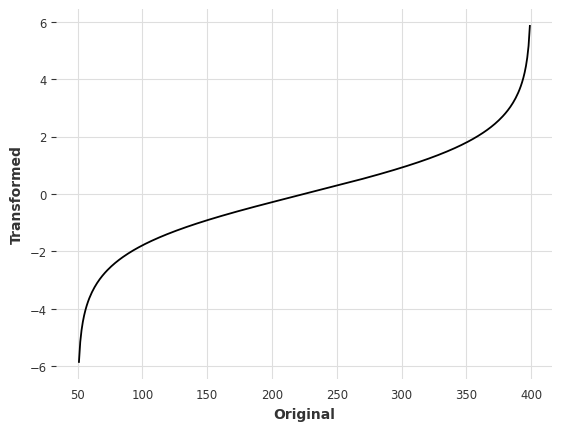

In [ ]:
x = np.linspace(51, 399, 349)
xt = [tgt_fn(v) for v in x]
plt.plot(x, xt)
plt.xlabel('Original')
plt.ylabel('Transformed')

## Holidays

When it comes to series based on human behavior (such as sales), holidays may play a big role explaining surges or seemingly unexpected data points.

DARTS provides some functionality ([`add_holidays()`](https://unit8co.github.io/darts/generated_api/darts.timeseries.html#darts.timeseries.TimeSeries.add_holidays)) for including holiday information based on the [`python-holidays` package](https://github.com/vacanza/python-holidays)